# Geospatial Operation and Analysis 


Why are we interested in geospatial data? Geospatial data is a type of data that is associated with a location. This location can be a point, a line, a polygon, or a raster. Geospatial data is becoming more and more important, yet the sheer volume of information that is generated made it difficult to handle. In this chapter, we will be exploring the use of GPU for manipulating large-scale geospatial data, and provide a practical example of how we can predict the presence of Aedes aegypti across the globe.


# Objective 

The objective of the third Case Study is to demonstrate the practical application of the common spatial data structures and operation with GPU-accelerated Python packages. The goal here is in twofold: 1) compare the computational speed of calculating point in polygon and 2) compare the computational speed of a classification model with raster data.

# Predicting the Presence of Aedes aegypti 

In this case study, we will be predicting the global presence and probability of Aedes aegypti, a mosquito species that is known to transmit dengue fever, chikungunya, and Zika virus. You can download the Aedes aegypti point occurrence data across the World from 1958 to 2014 here. We will also be using precipitation, temperature, elevation, and population density as predictor variables to capture the climatic, environmental and demographics variables. You can download the raster data from the GitHub repository here.



# Load datasets 

We will be dealing with both point occurrence and raster data for this exercise. The point data are remote-sensed fire detection locations across the State of California during the summer period of 2018. We will be using predictor variables that are climatic (i.e., temperature, precipitation, dryness), environmental (vegetation and elevation) and other social-anthropogenic (socioeconomic deprivation) gridded raster data for California.



In [1]:
#Import libraries
import rasterio
import cudf 
import geopandas as gpd 
import numpy as np 
import pandas as pd
import seaborn as sns 
import cuspatial  
# Load raster data 
precipitation = rasterio.open('./data/Global Raster/Precipitation/Global Averaged Precipitation 2000-14.tif')
temp = rasterio.open('./data/Global Raster/Temperature/Global Averaged Temperature 2000-14.tif')
elevation = rasterio.open('./data/Global Raster/Elevation/Global Land Surface Elevation.tif')
#light = rasterio.open('./data/Rasters/Brazil Natural Lighting.tif')
pop_density = rasterio.open('./data/Global Raster/Population Density/Global Population Density AveragedEst.tif')
#urbanisation = rasterio.open('./data/Rasters/Brazil Urbanisation 2013.tif')  

# Load Shapefile 
global_outline =gpd.read_file('./data/Global Shapefile/Global Outline/Global_All_0.shp',crs='EPSG:4326')
country_outline = gpd.read_file('./data/Global Shapefile/Global with Country Outline/Global_Countries_1.shp',crs='EPSG:4326') 

# Load Point occurence data 
aedes =pd.read_csv('./data/Global Raster/aedes_point.csv')
aedes_point = gpd.GeoDataFrame(aedes,geometry=gpd.points_from_xy(aedes['longitude'],aedes['latitude']),crs='EPSG:4326')

# Transformation 
global_outline.crs = ('+init=EPSG:4326')
country_outline.crs =('+init=EPSG:4326')  
aedes_point.crs = ('+init=EPSG:4326')

print(global_outline.crs ==aedes_point.crs)

/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


True


/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 1.0, 'Distribution of aedes occurence across the World')

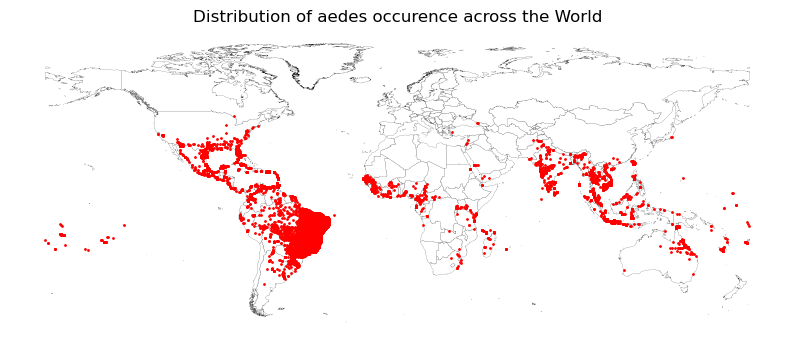

In [2]:
# Visualise point patterns 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,1, figsize = (10,10)) 
country_outline.plot(edgecolor='black',linewidth=0.1,ax=ax,color="white")
aedes_point.plot(ax=ax,color='red',markersize = 1) 
#show(light,ax=ax,cmap='viridis')
ax.axis('off')
ax.set_title("Distribution of aedes occurence across the World")

# Visualise study area to examine the spatial distribution  

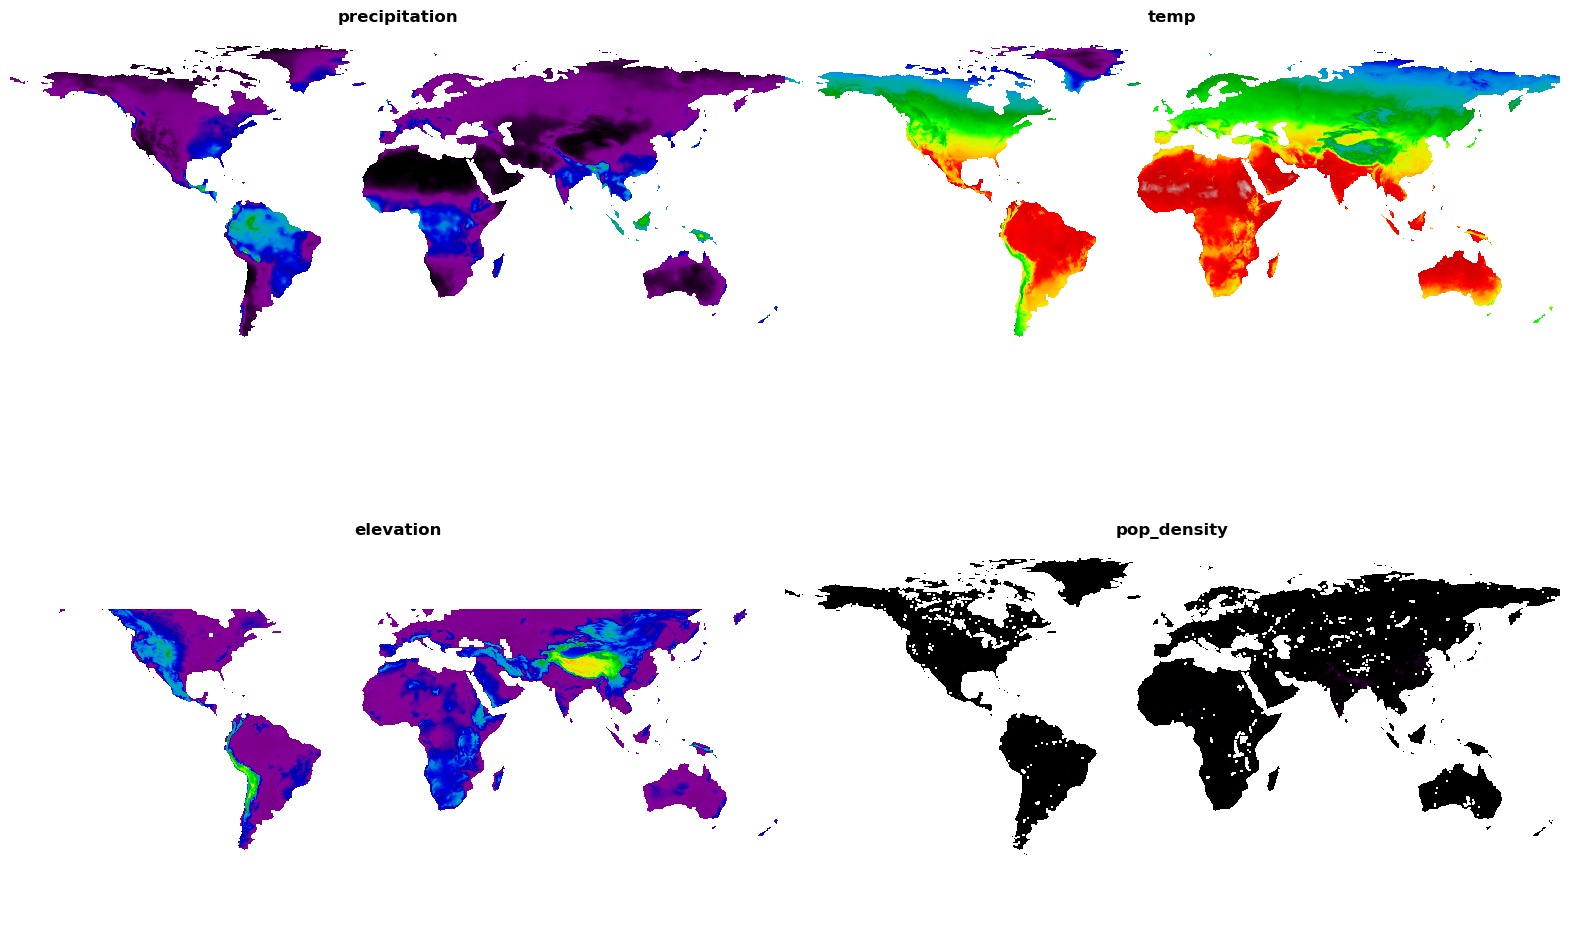

In [3]:
from rasterio.plot import show 
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,20))
title =["precipitation","temp","elevation","pop_density"] 
for index,attribute in enumerate([precipitation,temp,elevation,pop_density]):
     image = show(attribute,ax=ax[index//2,index%2],cmap='nipy_spectral',title = title[index])
     image.axis('off')
fig.subplots_adjust(hspace=-0.5, wspace=0)


# Prepare data for pseudo-background points as absence

In [4]:
# random seed 
import random
from shapely.geometry import Point
from tqdm import tqdm
random.seed(10)
def Random_Points_in_Polygon(polygon, number):
    bound = polygon.bounds.values[0]
    minx, miny, maxx, maxy = bound[0],bound[1],bound[2],bound[3]
    x_point,y_point = np.random.uniform(minx, maxx,size=number),np.random.uniform(miny,maxy,size=number) 
    return x_point,y_point
background_points = Random_Points_in_Polygon(global_outline,aedes_point.shape[0]*5)
background_points_shp = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=background_points[0],y=background_points[1]),crs='EPSG:4326')
background_points_shp.crs = global_outline.crs
print("Number of background points: ",background_points_shp.shape[0])


/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Number of background points:  95060


Text(0.5, 1.0, 'Distribution of background points across the World')

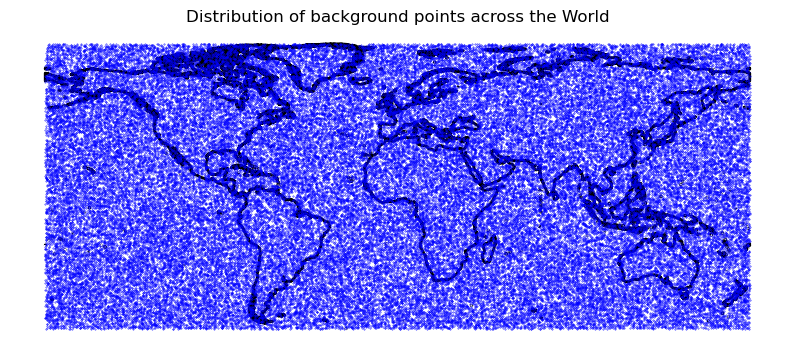

In [5]:
# Visualise point patterns 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,1, figsize = (10,10)) 
global_outline.plot(edgecolor='black',linewidth=2,ax=ax,color="white")
background_points_shp.plot(ax=ax,color='blue',markersize = 0.1) 
ax.axis('off')
ax.set_title("Distribution of background points across the World")



In [6]:
%%time 
pointInPolys = gpd.sjoin(background_points_shp, country_outline)

CPU times: user 8.39 s, sys: 33.9 ms, total: 8.43 s
Wall time: 8.45 s


In [10]:
%%time
# Cuspatial 
cu_countries_outline = cuspatial.read_polygon_shapefile('./data/Global Shapefile/Global with Country Outline/Global_Countries_1.shp')

background_points_df = cudf.DataFrame() 
background_points_df['Long'] = background_points[0]
background_points_df['Lat'] = background_points[1]
background_points_df['LocationID'] =  cu_countries_outline[0].shape[0] 
pip_iterations = list(np.arange(0, cu_countries_outline[0].shape[0], 31))

for i in range(len(pip_iterations)-1):
    start = pip_iterations[i]
    end = pip_iterations[i+1]
    pip_countries = cuspatial.point_in_polygon(background_points_df['Long'],background_points_df['Lat'],cu_countries_outline[0][start:end],cu_countries_outline[1],cu_countries_outline[2]['x'],cu_countries_outline[2]['y'])
    for j in pip_countries.columns:
        background_points_df['LocationID'].loc[pip_countries[j]] = j


CPU times: user 535 ms, sys: 8.16 ms, total: 543 ms
Wall time: 541 ms


## Stress Test 

In [ ]:
import time
cpu_time = []
gpu_time = []

for i in range(10,30):
    #Generate random background points
    background_points = Random_Points_in_Polygon(global_outline, aedes_point.shape[0] * i)

    #Preparing data on Geopandas 
    background_points_shp = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=background_points[0], y=background_points[1]), crs='EPSG:4326')
    background_points_shp.crs = global_outline.crs
    #cpu runtime -------------------------------- 
    start = time.time()
    CPU_pointInPolys = gpd.sjoin(background_points_shp, country_outline)
    end = time.time()
    cpu_time.append(end - start)

    #Preparing data on cudf 
    background_points_df = cudf.DataFrame()
    background_points_df['Long'] = background_points[0]
    background_points_df['Lat'] = background_points[1]
    background_points_df['LocationID'] = cu_countries_outline[0].shape[0]
    pip_iterations = list(np.arange(0, cu_countries_outline[0].shape[0], 31))

    #gpu runtime --------------------------------
    start = time.time()
    for iter in range(len(pip_iterations) - 1):
        pip_start = pip_iterations[iter]
        pip_end = pip_iterations[iter + 1]
        pip_countries = cuspatial.point_in_polygon(background_points_df['Long'], background_points_df['Lat'], cu_countries_outline[0][pip_start:pip_end], cu_countries_outline[1], cu_countries_outline[2]['x'], cu_countries_outline[2]['y'])
        for j in pip_countries.columns:
            background_points_df['LocationID'].loc[pip_countries[j]] = j
    end = time.time()
    gpu_time.append(end - start)


/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/home/zcfajct@ad.ucl.ac.uk/.conda/env

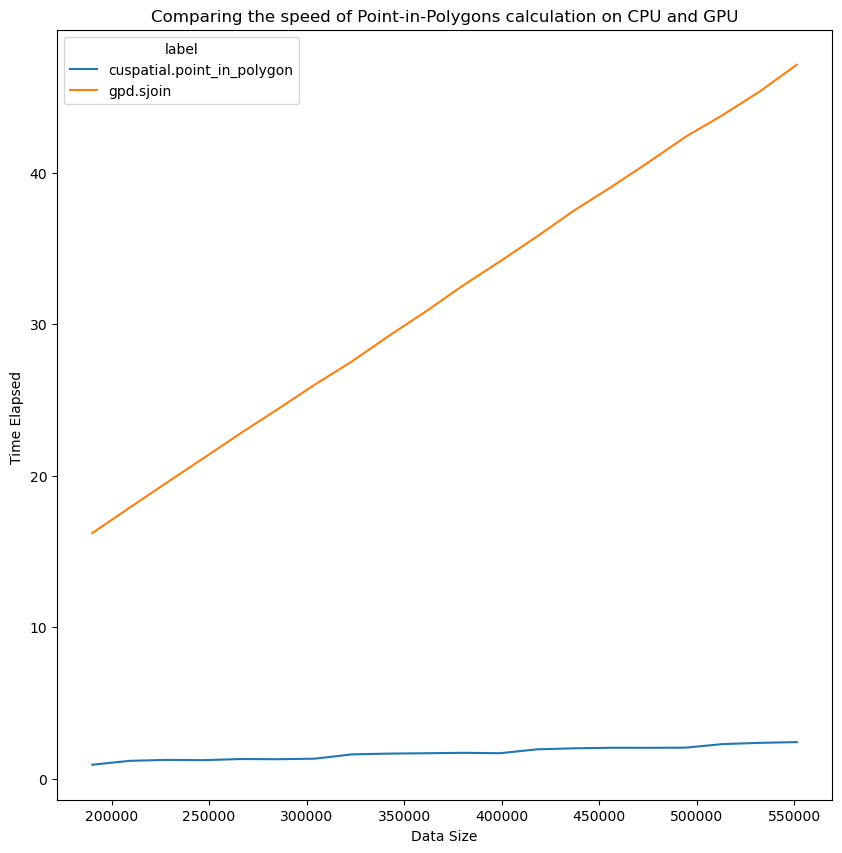

In [ ]:
#Create a dataframe to store the results
gpu_elapsed = pd.DataFrame({"time":gpu_time,"data_size":[aedes_point.shape[0]* i for i in range(10,30)],'label':"cuspatial.point_in_polygon"})
cpu_elapsed = pd.DataFrame({"time":cpu_time,"data_size":[aedes_point.shape[0]* i for i in range(10,30)],'label':"gpd.sjoin"})
result = pd.concat([gpu_elapsed,cpu_elapsed]).reset_index()

#Plot results
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x= 'data_size',y='time',hue = 'label',data = result,ax = ax )
plt.xlabel('Data Size')
plt.ylabel("Time Elapsed ")
plt.title("Comparing the speed of Point-in-Polygons calculation on CPU and GPU") 
plt.show()

## Visualise point patterns 

/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Distribution of background points across Brazil')

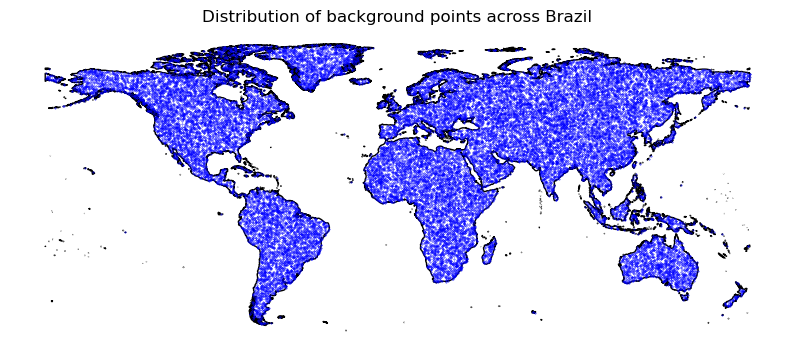

In [ ]:
# Visualise point patterns
background_points = Random_Points_in_Polygon(global_outline,aedes_point.shape[0]*5)
background_points_df = cudf.DataFrame() 
background_points_df['Long'] = background_points[0]
background_points_df['Lat'] = background_points[1]
background_points_df['LocationID'] =  cu_countries_outline[0].shape[0] 
pip_iterations = list(np.arange(0, cu_countries_outline[0].shape[0], 31))

for i in range(len(pip_iterations)-1):
    start = pip_iterations[i]
    end = pip_iterations[i+1]
    pip_countries = cuspatial.point_in_polygon(background_points_df['Long'],background_points_df['Lat'],cu_countries_outline[0][start:end],cu_countries_outline[1],cu_countries_outline[2]['x'],cu_countries_outline[2]['y'])
    for j in pip_countries.columns:
        background_points_df['LocationID'].loc[pip_countries[j]] = j

pointInPolys = background_points_df.query("LocationID != 250")  
pointInPolys = gpd.GeoDataFrame(geometry = gpd.points_from_xy(pointInPolys['Long'].to_numpy(),pointInPolys['Lat'].to_numpy()),crs="EPSG:4326")
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,1, figsize = (10,10)) 
global_outline.plot(edgecolor='black',linewidth=1,ax=ax,color="white")
pointInPolys.plot(ax=ax,color='blue',markersize = 0.1) 
ax.axis('off')
ax.set_title("Distribution of background points across Brazil")



## Create a multi-band raster  

To facilitate the required analysis, it is necessary to construct a multi-band raster object from the predictor variables. A band is essentially a matrix of cell values, and a raster with multiple bands comprises multiple matrices of cell values that overlap spatially and represent the same geographic region. For example, the raster object for temperature is a single-band raster object. However, if we stack raster objects for variables such as precipitation, population density and elevation on top of the temperature raster, we create a multi-band raster object. This object will have four bands, each corresponding to a single matrix of cell values.

The creation of this multi-band raster object is essential to perform the extraction of raster values from all variables at occurrence points in a single step. Additionally, the entire multi-band raster object is required for estimating and predicting spatial data.

In [95]:
meta = precipitation.meta
meta.update(count = 4)
with rasterio.open('./data/Global Raster/global_stack.tif', 'w',**meta) as dst:
    for index,attribute in enumerate([precipitation,temp,elevation,pop_density],start=1): 
        dst.write(attribute.read(1),index)
stack = rasterio.open('./data/Global Raster/global_stack.tif')         

# Extraction of all raster values from predictor variables onto presence-absence points 

In [96]:
# Extrat raster values 
background_list = [(x,y) for x,y in zip(pointInPolys['geometry'].x , pointInPolys['geometry'].y)]
pointInPolys['value'] = [x for x in stack.sample(background_list)]

aedes_list = [(x,y) for x,y in zip(aedes_point['geometry'].x , aedes_point['geometry'].y)]
aedes_point['value'] = [x for x in stack.sample(aedes_list)]

# Convert into dataframe 
aedes_env = pd.DataFrame(np.vstack(aedes_point['value']),columns=title)
aedes_env['Presence'] = 1
background_env = pd.DataFrame(np.vstack(pointInPolys['value']),columns=title)
background_env['Presence'] = 0 

#Merge 
input_data = pd.concat([aedes_env,background_env],axis=0)
input_data[input_data<0]  =0


# Preparation of training & test data for prediction & model cross-validation


In [97]:
#Split train,test set 
from sklearn.model_selection import train_test_split
y= input_data.pop('Presence')
X = input_data 
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8)

# Random Forest Classification Model with CuML and Scikit-learn 


In [128]:
%%time 
from sklearn.ensemble import RandomForestClassifier
sk_model = RandomForestClassifier(max_depth=20, random_state=42,n_estimators=100)
sk_model.fit(X_train,y_train)
y_pred =sk_model.predict(X_test)

CPU times: user 4.63 s, sys: 9.95 ms, total: 4.64 s
Wall time: 4.65 s


In [129]:
%%time 
#cuml 
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cuRFC
cuml_model = cuRFC(max_depth=20, random_state=42,n_estimators=100)
cuml_model.fit(cp.array(X_train),cp.array(y_train)) 
cuml_predict = cuml_model.predict(cp.array(X_test))

/home/zcfajct@ad.ucl.ac.uk/.conda/envs/GPU_notebook/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


CPU times: user 2.81 s, sys: 359 ms, total: 3.17 s
Wall time: 341 ms


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9372446306966998


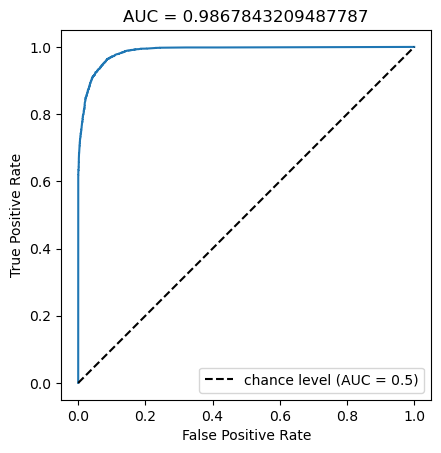

Max TRP+TNR: 0.36108708


In [136]:
# Model accuracy  
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test,cp.asnumpy(cuml_predict)))
from sklearn.metrics import RocCurveDisplay

y_pred_proba = cuml_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)
plt.legend(loc=4)


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC = {}".format(auc))
plt.legend()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Max TRP+TNR:", optimal_threshold)



## Model validation and examination of the predictor’s contribution 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


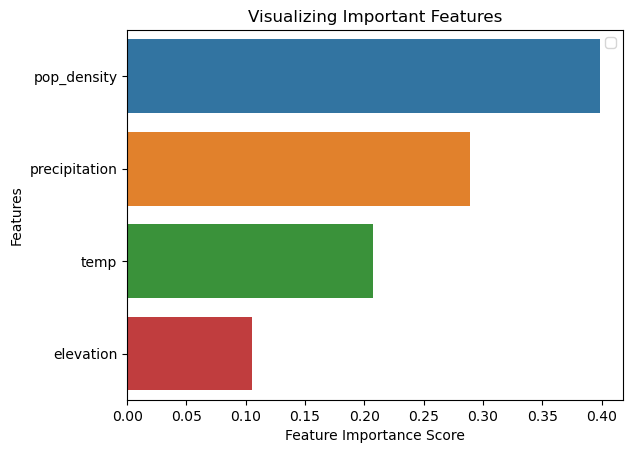

In [138]:
# Feature importance 
import pandas as pd
feature_imp = pd.Series(sk_model.feature_importances_,index=title).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Mapping the predicted probability of presence of Aedes aegypti 



In [101]:
# Mapping predicted probability and suitability
input_matrix = stack.read()  
#input shape (6, 945, 1093)
#Convert into (6,945* 1093 )
converted_env = [] 
for i in range(4): 
    attr = input_matrix[i,:,:].reshape(input_matrix.shape[1]*input_matrix.shape[2],1)
    converted_env.append(attr)

converted_env = pd.DataFrame(np.hstack(converted_env),columns=title)
converted_env[converted_env<0] =0

In [140]:
%%time
y_pred =sk_model.predict_proba(converted_env)[::,-1]

CPU times: user 2min 29s, sys: 22.1 s, total: 2min 51s
Wall time: 2min 51s


In [169]:
%%time 
y_pred =cuml_model.predict_proba(converted_env)[::,-1]

CPU times: user 2.13 s, sys: 470 ms, total: 2.6 s
Wall time: 1.62 s


In [170]:
with rasterio.open('./data/Global Raster/prediction.tif', 'w',**meta) as dst:
    dst.write(cp.asnumpy(y_pred).reshape((input_matrix.shape[1],input_matrix.shape[2])),1) 

# Generate final output which shows grid cells with probability > 0.3611     
trigger = y_pred
trigger[trigger >0.36108708]  = 1
trigger[trigger < 0.36108708]  = 0
with rasterio.open('./data/Global Raster/trigger.tif', 'w',**meta) as dst:
    dst.write(cp.asnumpy(trigger).reshape((input_matrix.shape[1],input_matrix.shape[2])),1)     


In [171]:
prediction = rasterio.open('./data/Global Raster/prediction.tif') 
trigger = rasterio.open('./data/Global Raster/trigger.tif')    

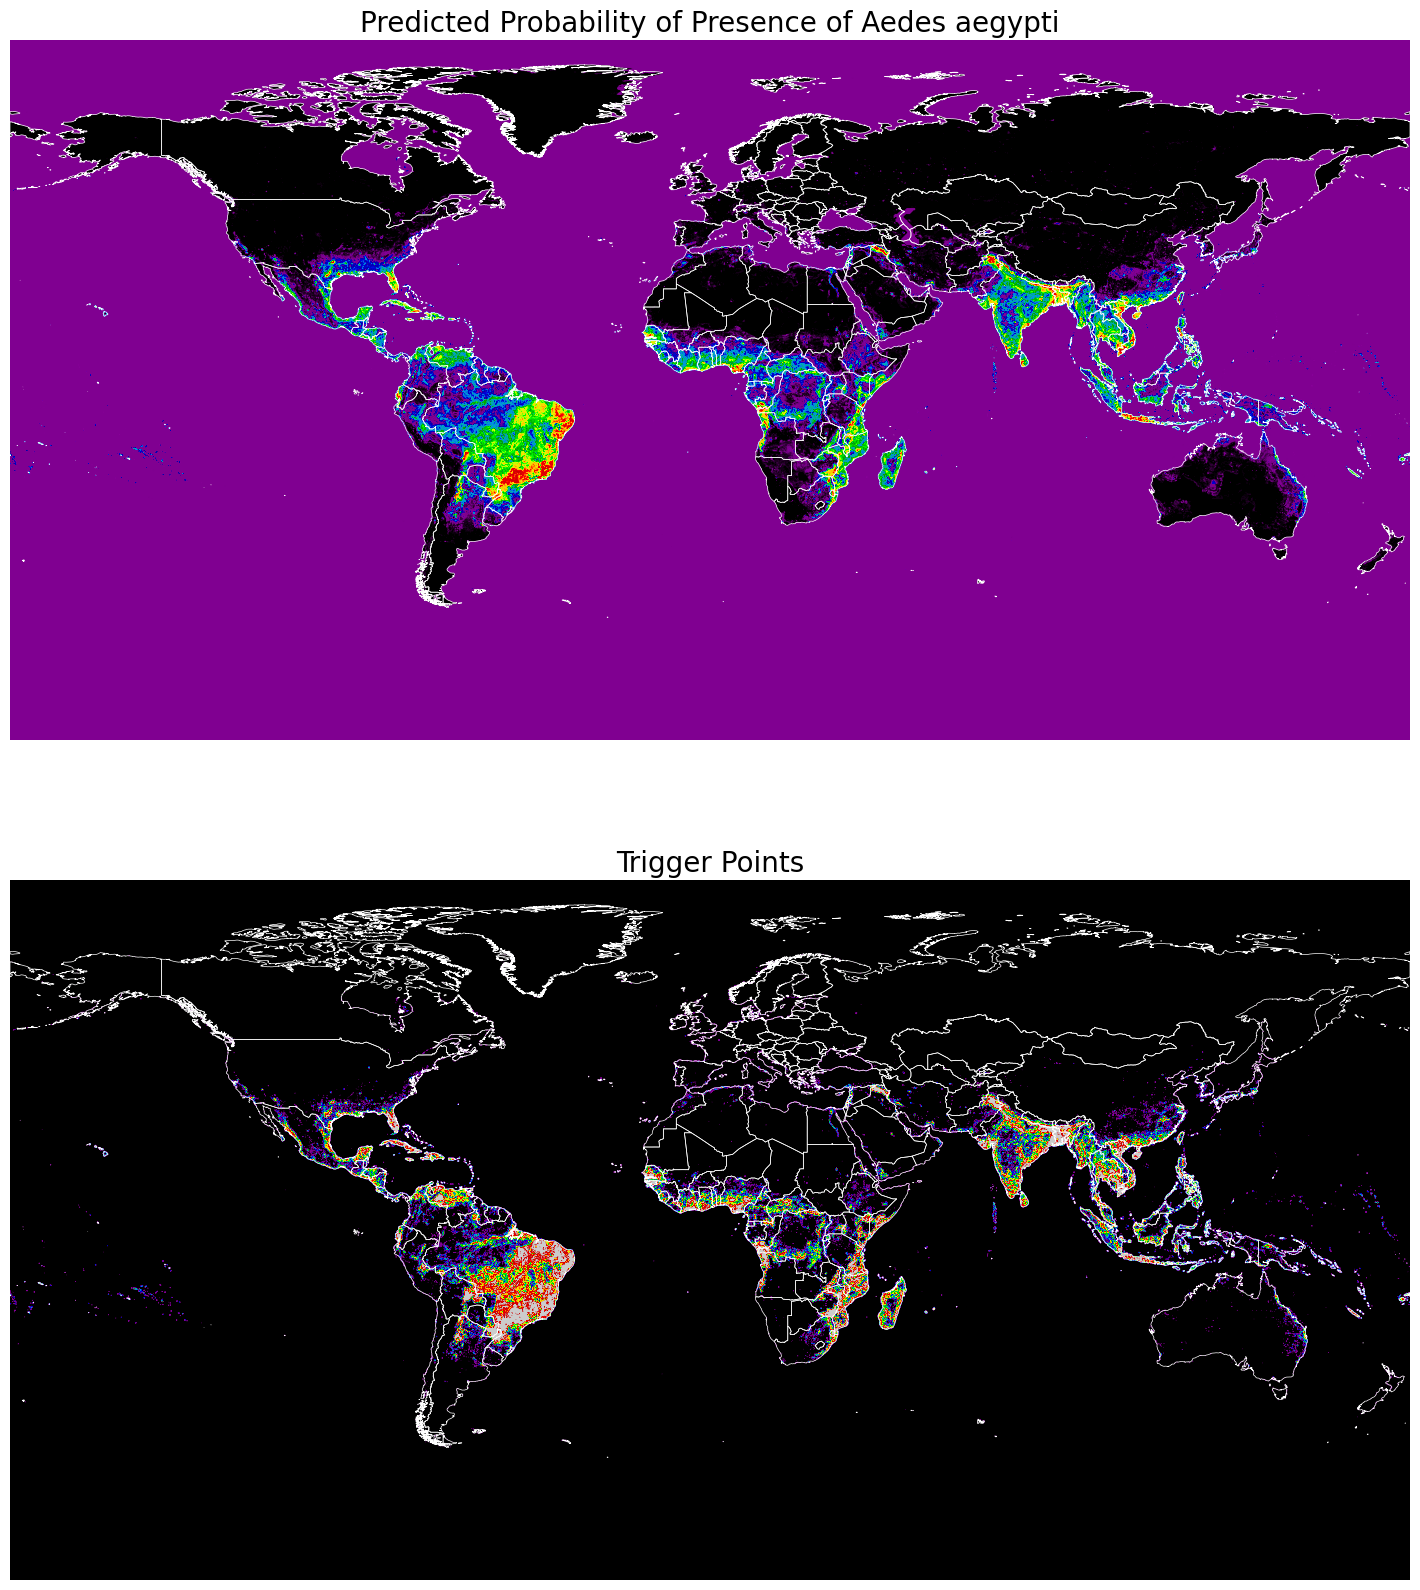

In [179]:
fig,ax= plt.subplots(2,1,figsize=(20,20))
country_outline.boundary.plot(edgecolor='white',linewidth=0.5,ax=ax[0])
show(prediction,cmap='nipy_spectral',ax=ax[0])

country_outline.boundary.plot(edgecolor='white',linewidth=0.5,ax=ax[1])
show(trigger,cmap='nipy_spectral',ax=ax[1])

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('Predicted Probability of Presence of Aedes aegypti',fontsize=20)
ax[1].set_title('Trigger Points',fontsize=20)
plt.show()